## Can GPT4 Solve the ARC Challenge?
This notebook was created by John Tan Chong Min on 17 Apr 2023.
- Seek to use GPT4 via zero-shot prompt engineering to generate an output
- Fine-tuning the prompt to let GPT4 ground its answer has proven effective
- Works quite well for grids with small sizes
- Can be better if we ask GPT4 to generate the python code for its description, and use it to check validity based on input/output pairs.
- Can be even better if we have GPT4s with different biases and grounding, and increase diversity of possible generated code

In [85]:
import json
import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np
import os
import copy
import traceback
from io import StringIO
from collections import defaultdict

def load_json_data(folder):
    json_files = [pos_json for pos_json in os.listdir(folder) if pos_json.endswith('.json')]
    data = {}
    for js in json_files:
        with open(os.path.join(folder, js)) as json_file:
            data[js] = json.load(json_file)
    return data

def plot_2d_grid(data):
    
    cvals  = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    colors = ["black", "dodgerblue", "red", "lightgreen", "yellow", "grey", "magenta", "orange", "lightblue", "brown"]
    norm=plt.Normalize(min(cvals),max(cvals))
    tuples = list(zip(map(norm,cvals), colors))
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", tuples)

    fig, axs = plt.subplots(len(data['test']), 3, figsize=(5, len(data['test']) * 3 * 0.7))
    axs = axs.reshape(-1, 3)  # Reshape axs to have 2 dimensions        
    
    # show grid
    for i, example in enumerate(data['test']):
        axs[i, 0].set_title(f'Test Input {i+1}')
        # display gridlines
        rows, cols = np.array(string_to_array(example['input'])).shape
        axs[i, 0].set_xticks(np.arange(cols + 1) - 0.5, minor=True)
        axs[i, 0].set_yticks(np.arange(rows + 1) - 0.5, minor=True)
        axs[i, 0].grid(True, which='minor', color='black', linewidth=0.5)
        axs[i, 0].set_xticks([]); axs[i, 0].set_yticks([])
        axs[i, 0].imshow(np.array(string_to_array(example['input'])), cmap=cmap, vmin=0, vmax=9)
        
        axs[i, 1].set_title(f'Test Output {i+1}')
        # display gridlines
        rows, cols = np.array(string_to_array(example['output'])).shape
        axs[i, 1].set_xticks(np.arange(cols + 1) - 0.5, minor=True)
        axs[i, 1].set_yticks(np.arange(rows + 1) - 0.5, minor=True)
        axs[i, 1].grid(True, which='minor', color='black', linewidth=0.5)
        axs[i, 1].set_xticks([]); axs[i, 1].set_yticks([])
        axs[i, 1].imshow(np.array(string_to_array(example['output'])), cmap=cmap, vmin=0, vmax=9)
        # plot gpt output if present
        if 'code_output' in example:
            axs[i, 2].set_title(f'GPT Output {i+1}')
            # display gridlines
            rows, cols = np.array(string_to_array(example['code_output'])).shape
            axs[i, 2].set_xticks(np.arange(cols + 1) - 0.5, minor=True)
            axs[i, 2].set_yticks(np.arange(rows + 1) - 0.5, minor=True)
            axs[i, 2].grid(True, which='minor', color='black', linewidth=0.5)
            axs[i, 2].set_xticks([]); axs[i, 2].set_yticks([])
            axs[i, 2].imshow(np.array(string_to_array(example['code_output'])), cmap=cmap, vmin=0, vmax=9)
        else:
            axs[i, 2].axis('off')
    plt.tight_layout()
    plt.show()

    fig, axs = plt.subplots(len(data['train']), 3, figsize=(5, len(data['train']) * 3 * 0.7))
    axs = axs.reshape(-1, 3)  # Reshape axs to have 2 dimensions
    for i, example in enumerate(data['train']):
        axs[i, 0].set_title(f'Training Input {i+1}')
        # display gridlines
        rows, cols = np.array(string_to_array(example['input'])).shape
        axs[i, 0].set_xticks(np.arange(cols + 1) - 0.5, minor=True)
        axs[i, 0].set_yticks(np.arange(rows + 1) - 0.5, minor=True)
        axs[i, 0].grid(True, which='minor', color='black', linewidth=0.5)
        axs[i, 0].set_xticks([]); axs[i, 0].set_yticks([])
        axs[i, 0].imshow(np.array(string_to_array(example['input'])), cmap=cmap, vmin=0, vmax=9)
        
        axs[i, 1].set_title(f'Training Output {i+1}')
        # display gridlines
        rows, cols = np.array(string_to_array(example['output'])).shape
        axs[i, 1].set_xticks(np.arange(cols + 1) - 0.5, minor=True)
        axs[i, 1].set_yticks(np.arange(rows + 1) - 0.5, minor=True)
        axs[i, 1].grid(True, which='minor', color='black', linewidth=0.5)
        axs[i, 1].set_xticks([]); axs[i, 1].set_yticks([])
        axs[i, 1].imshow(np.array(string_to_array(example['output'])), cmap=cmap, vmin=0, vmax=9)
        if 'code_output' in example:
            axs[i, 2].set_title(f'GPT Output {i+1}')
            # display gridlines
            rows, cols = np.array(string_to_array(example['code_output'])).shape
            axs[i, 2].set_xticks(np.arange(cols + 1) - 0.5, minor=True)
            axs[i, 2].set_yticks(np.arange(rows + 1) - 0.5, minor=True)
            axs[i, 2].grid(True, which='minor', color='black', linewidth=0.5)
            axs[i, 2].set_xticks([]); axs[i, 2].set_yticks([])
            axs[i, 2].imshow(np.array(string_to_array(example['code_output'])), cmap=cmap, vmin=0, vmax=9)
        else:
            axs[i, 2].axis('off')
    plt.tight_layout()
    plt.show()

# Utility functions for objects

In [117]:
def get_size(grid):
    ''' Returns the size of the grid in 2 axis '''
    return (len(grid), len(grid[0]))
def get_middle(coords):
    ''' Returns the middle of the coordinates '''
    x_sum, y_sum = 0, 0
    for (x,y) in coords:
        x_sum += int(x)
        y_sum += int(y)
    return (int(x_sum/len(coords)+0.5), int(y_sum/len(coords)+0.5))
def get_anchor(coords):
    ''' Returns the top left, and bottom right anchor of the shape '''
    min_x, min_y = 10000, 10000
    max_x, max_y = 0, 0
    for (x, y) in coords:
        min_x = min(x, min_x)
        min_y = min(y, min_y)
        max_x = max(x, max_x)
        max_y = max(y, max_y)
    return (min_x, min_y), (max_x, max_y)
def get_shape(coords, value='x'):
    ''' Gets shape based on the coords '''
    (min_x, min_y), (max_x, max_y) = get_anchor(coords)
    newgrid = np.array([['.' for _ in range(max_y-min_y+1)] for _ in range(max_x-min_x+1)])
    for (x, y) in coords:
        newgrid[x-min_x, y-min_y]=value
    return [''.join(row) for row in newgrid]

def array_to_string(grid):
    # if grid is already in string form, just return it
    if isinstance(grid[0][0], str): return grid

    newgrid = []
    mapping = {0:'.',1:'a',2:'b',3:'c',4:'d',5:'e',6:'f',7:'g',8:'h',9:'i',10:'j'}
    for i in range(len(grid)):
        curstring = ''
        for j in range(len(grid[0])):
            curstring += mapping[grid[i][j]]
        newgrid.append(curstring)
    return newgrid

def string_to_array(grid):
    # if grid is already in integer form, just return it
    if isinstance(grid[0][0], int): return grid

    mapping = {0:'.',1:'a',2:'b',3:'c',4:'d',5:'e',6:'f',7:'g',8:'h',9:'i',10:'j'}
    revmap = {v:k for k,v in mapping.items()}
    newgrid = [[revmap[grid[i][j]] for j in range(len(grid[0]))] for i in range(len(grid))]
    return newgrid

## Helper Function
- Function to help GPT execute tasks

In [118]:
def get_objects(grid, diag = False, empty = False):
    rows = len(grid)
    cols = len(grid[0])
    visited = set()
    objects = []

    def is_valid(row, col, value):
        return 0 <= row < rows and 0 <= col < cols and (row, col) not in visited and grid[row][col] == value

    def dfs(row, col, value):
        if is_valid(row, col, value):
            visited.add((row, col))
            object_coords.add((row, col))
            dfs(row - 1, col, value)  # up
            dfs(row + 1, col, value)  # down
            dfs(row, col - 1, value)  # left
            dfs(row, col + 1, value)  # right
            if diag:
                dfs(row - 1, col - 1, value)  # top-left diagonal
                dfs(row - 1, col + 1, value)  # top-right diagonal
                dfs(row + 1, col - 1, value)  # bottom-left diagonal
                dfs(row + 1, col + 1, value)  # bottom-right diagonal

    for row in range(rows):
        for col in range(cols):
            value = grid[row][col]
            if (row, col) not in visited:
                if (value == '.' or value == 0) and not empty: continue
                object_coords = set()
                dfs(row, col, value)
                (min_x, min_y), (max_x, max_y) = get_anchor(object_coords)
                objects.append({'tl':(min_x, min_y),'br':(max_x, max_y),
                                 'shape':get_shape(object_coords), 'value': value, 'num':len(object_coords)})

    return objects

In [119]:
get_objects(array_to_string([[0, 1, 1, 1], [0, 0, 2, 1]]))

[{'tl': (0, 1), 'br': (1, 3), 'shape': ['xxx', '..x'], 'value': 'a', 'num': 4},
 {'tl': (1, 2), 'br': (1, 2), 'shape': ['x'], 'value': 'b', 'num': 1}]

In [120]:
def shape_to_coords(shape, top_left): 
    '''Takes in object shape and top-left anchor, outputs list of coords object occupies'''
    row, col = len(shape), len(shape[0])
    coords = []
    for i in range(row):
        for j in range(col):
            if shape[i][j]!='.' and shape[i][j]!=0:coords.append((i+top_left[0],j+top_left[1]))
    return coords

def fill_object(grid, obj_dict): 
    '''Returns grid filled with the object'''
    newgrid = [list(row) for row in grid]
    obj_coords = shape_to_coords(obj_dict['shape'], obj_dict['tl'])
    for x,y in obj_coords:
        if 0<=x<len(grid) and 0<=y<len(grid[0]): newgrid[x][y] = obj_dict['value']
    return [''.join(row) for row in newgrid]

def empty_grid(row, col):
    ''' Returns an empty grid of height row and width col '''
    newgrid = [['.' for _ in range(col)] for _ in range(row)]
    return [''.join(row) for row in newgrid]

In [121]:
def crop_section(grid, tl, br): 
    ''' returns a subset of the grid from top-left to bottom-right coordinate '''
    newgrid = [[grid[i][j] for j in range(tl[1],br[1]+1)] for i in range(tl[0],br[0]+1)]
    return [''.join(row) for row in newgrid]

def fill_section(grid, tl, br, value): 
    ''' fills up grid section from top-left to bottom-right coordinate, with value '''
    newgrid = [list(row) for row in grid]
    for row in range(tl[0], br[0]+1):
        for col in range(tl[1], br[1]+1):
            newgrid[row][col] = value
    return [''.join(row) for row in newgrid]

def get_coords(grid, value):
    ''' get all coordinates of filled pixels of a certain value in grid '''
    coords = []
    for row in range(len(grid)):
        for col in range(len(grid[0])):
            if grid[row][col] == value:
                coords.append((row, col))
    return coords

def fill_line_between_coords(grid, coord1, coord2, value): 
    '''fills up a line from coord1 to coord2 with value'''
    if coord1 == coord2: return grid
    newgrid = [list(row) for row in grid]
    row_diff = coord1[0]-coord2[0]
    col_diff = coord1[1]-coord2[1]
    maxdist = max(abs(row_diff), abs(col_diff))
    for i in range(maxdist+1):
        newgrid[coord1[0]-(i*row_diff)//maxdist][coord1[1]-(i*col_diff)//maxdist] = value
    return [''.join(row) for row in newgrid]

def get_counts(grid, empty = False):
    ''' returns a sorted list of the counts of various values within the grid '''
    d = defaultdict(lambda: 0)
    for row in grid:
        for cell in row:
            d[cell] += 1
    # delete the empty cells as an entry if empty is False
    if not empty and '.' in d:
        del d['.']
    sorted_list = sorted(d.items(), key=lambda item: item[1], reverse = True)
    return sorted_list

In [193]:
def rotate_clockwise(grid, degree=90):
    ''' Rotates grid clockwise by a degree of 90, 180, 270 degrees. grid can also be the object dictionary'''
    # process object dictionary differently
    if isinstance(grid, dict):
        obj_dict = copy.deepcopy(grid)
        newgrid = obj_dict['shape']
        for i in range(degree//90):
            # Transpose the array
            transposed_grid = [[newgrid[j][i] for j in range(len(newgrid))] for i in range(len(newgrid[0]))]

            # Reverse each row of the transposed array
            newgrid = [row[::-1] for row in transposed_grid]
        newgrid = [''.join(row) for row in newgrid]
        obj_dict['shape'] = newgrid
        start_x, start_y = obj_dict['tl']
        obj_dict['br'] = (start_x + len(newgrid)-1, start_y + len(newgrid[0])-1)
        return obj_dict
    
    else:
        newgrid = [list(row) for row in grid]
        for i in range(degree//90):
            # Transpose the array
            transposed_grid = [[newgrid[j][i] for j in range(len(newgrid))] for i in range(len(newgrid[0]))]

            # Reverse each row of the transposed array
            newgrid = [row[::-1] for row in transposed_grid]

        return [''.join(row) for row in newgrid]

def horizontal_flip(grid):
    ''' Does a horizontal flip of the grid. grid can also be the object dictionary'''
    # process object dictionary differently
    if isinstance(grid, dict):
        obj_dict = copy.deepcopy(grid)
        obj_dict['shape'] = [row[::-1] for row in obj_dict['shape']]
        start_x, start_y = obj_dict['tl']
        obj_dict['br'] = (start_x + len(obj_dict['shape'])-1, start_y + len(obj_dict['shape'][0])-1)
        return obj_dict
        
    else:
        return [row[::-1] for row in grid]

def vertical_flip(grid):
    ''' Does a vertical flip of the grid. grid can also be the object dictionary'''
    # process object dictionary differently
    if isinstance(grid, dict):
        obj_dict = copy.deepcopy(grid)
        obj_dict['shape'] = [row for row in obj_dict['shape'][::-1]]
        start_x, start_y = obj_dict['tl']
        obj_dict['br'] = (start_x + len(obj_dict['shape'])-1, start_y + len(obj_dict['shape'][0])-1)
        return obj_dict
    
    else:
        return [row for row in grid[::-1]]

### Unit Tests

In [194]:
assert shape_to_coords(['..a','aaa'], (3,3)) == [(3, 5), (4, 3), (4, 4), (4, 5)]
assert fill_object(['....','....'], {'tl': (0, 1),'br': (1, 3),'shape': ['xxx', '..x'],'value': 'a','num': 4}) == ['.aaa', '...a']
assert empty_grid(3, 2) == ['..', '..', '..']
assert crop_section(['aab','.ab'], (0, 0), (1, 1)) == ['aa', '.a']
assert fill_section(['...', '...'], (0, 0), (1, 1), 'a') == ['aa.', 'aa.']
assert get_coords(['.a.', '..a'], 'a') == [(0, 1), (1, 2)]
assert fill_line_between_coords(['...','...'], (0, 0), (1, 1), 'a') == ['a..', '.a.']
assert fill_line_between_coords(['...','...'], (0, 0), (0, 1), 'a') == ['aa.', '...']
assert fill_line_between_coords(['...','...'], (0, 0), (1, 0), 'a') == ['a..', 'a..']
assert get_counts(['..b','b.a']) == [('b', 2), ('a', 1)]
assert rotate_clockwise(['abc','def'], 90) == ['da', 'eb', 'fc']
assert rotate_clockwise(['abc','def', 'ghi'], 180) == ['ihg', 'fed', 'cba']
assert rotate_clockwise(['abc','def'], 270) == ['cf', 'be', 'ad']
assert rotate_clockwise({'tl': (0, 1),'br': (1, 3),'shape': ['xxx', '..x'],'value': 'a','num': 4}, 90) == {'tl': (0, 1),'br': (2, 2),'shape': ['.x', '.x', 'xx'],'value': 'a','num': 4}
assert horizontal_flip(['abc','def']) == ['cba', 'fed']
assert horizontal_flip({'tl': (0, 1),'br': (1, 3),'shape': ['xxx', '..x'],'value': 'a','num': 4}) == {'tl': (0, 1), 'br': (1, 3), 'shape': ['xxx', 'x..'], 'value': 'a', 'num': 4}
assert vertical_flip(['abc','def']) == ['def', 'abc']
assert vertical_flip({'tl': (0, 1),'br': (1, 3),'shape': ['xxx', '..x'],'value': 'a','num': 4}) == {'tl': (0, 1), 'br': (1, 3), 'shape': ['..x', 'xxx'], 'value': 'a', 'num': 4}

## Conditional Functions
- Functions to help with deciding when to use helper functions

In [195]:
def on_same_line(coord1, coord2, line_type):
    '''Returns True/False if coord1 is on the same line as coord2. line_type can be one of ['row', 'col', 'diag']'''
    if line_type == 'row': return coord1[0] == coord2[0]
    if line_type == 'col': return coord1[1] == coord2[1]
    if line_type == 'diag': return coord1[0]-coord2[0] == coord1[1]-coord2[1]
    return False

### Unit Tests

In [196]:
assert on_same_line((1, 1), (2, 2), 'diag') == True

## Load the JSON files

- Download from https://lab42.global/wp-content/uploads/2022/08/ARC-800-tasks.zip

In [197]:
# !wget https://lab42.global/wp-content/uploads/2022/08/ARC-800-tasks.zip 
# !unzip ARC-800-tasks.zip -d ./ARC-800-tasks

In [198]:
# load the json files

# download the data from 
folder = 'ARC-800-tasks/training'
myjson = load_json_data(folder)

file_names = list(myjson.keys())

## Get the JSON for the GPT input

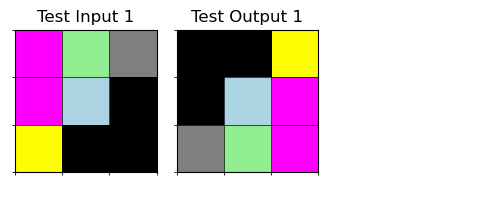

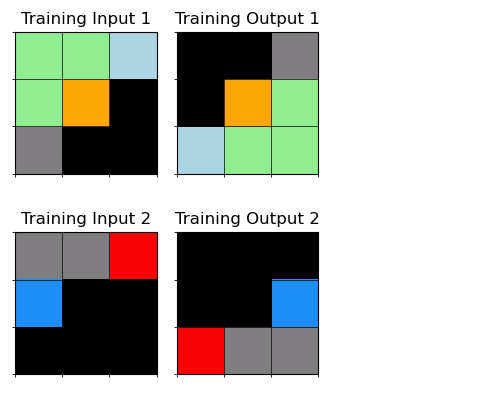

In [199]:
index = 59
task_name = file_names[index]
json_task = copy.deepcopy(myjson[task_name])
plot_2d_grid(json_task)
correct = False
test_correct = False

## Give GPT the size and object view as well

In [200]:
for each in json_task['train']:
    # convert to string representation
    for field in ['input', 'output', 'code_output']:
        if field in each: each[field] = array_to_string(each[field])
    each['input_grid_size'] = get_size(each['input'])
    each['input_objects'] = get_objects(each['input'])
    each['output_grid_size'] = get_size(each['output'])
    each['output_objects'] = get_objects(each['output'])
for each in json_task['test']:
    # convert to string representation
    for field in ['input', 'output', 'code_output']:
        if field in each: each[field] = array_to_string(each[field])
    each['input_grid_size'] = get_size(each['input'])
    each['input_objects'] = get_objects(each['input'])
    each['output_grid_size'] = get_size(each['output'])
    each['output_objects'] = get_objects(each['output'])

## Original code to just use GPT-language without code

In [201]:
# preamble = '''You are given a series of inputs and output pairs. 
# These are all in the form of a 2D array, representing a 2D grid, with values from 0-9. 
# The values are not representative of any ordinal ranking. Do not sum them or modulo them.
# Input/output pairs may not reflect all possibilities, you are to infer the simplest possible relation making use of symmetry and invariance as much as possible.

# The input can be something like:
# > entire grid being the sandbox to manipulate
# > using a part of the grid (individual squares or portions of the grid) to depict instructions of how to do the task. Position and symmetry is very important.
# > using regions of similar value to depict area for answer of the task

# The output can be something like:
# > same output size as input after performing action
# > output one of the fixed predetermined patterns used to classify the input image
# > using output to show the ordering of objects, such as by size, height, width, position, value

# Each of the input-output relation can be done with one or more actions chained together, which could be something like (not exhaustive):
# - picture view 
# "Use Condition: When there are a lot more variety in output pixels than the input"
# > create lines based on certain object positions
# > make common shapes
# > rotation / reflection symmetry
# > fill up the occluded part

# - object view (an object is defined as continuous squares connected horizontally, vertically and/or diagonally, separated by 0 values)
# "Use Condition: When input and output have similar object types"
# > objects can be the of the same value, or different values combined together
# > objects may be hidden beneath other objects
# > rotating or shifting objects
# > changing value of object
# > objects can be manipulated and mapped to a different number of output squares
# > different objects may be manipulated differently based on context

# - physics view
# "Use condition: When the output contains more pixels than the input, and the pixels are more connected"
# > continue what a trajectory would look like
# > apply gravity on certain pixels
# > follow the path of a light beam

# - section view
# "Use condition: When input grid can be split into multiple sections to overlay into the output grid"
# > combine two or more sections of the input into one single one based on a simple rule
# > rule can be overlay of top section over bottom, or a logical operator such as AND, OR, XOR'''

# postamble = '''Do not provide explanations. Output only the following in .json format:
# "overall_pattern": {describe the simplest input-output relationship for all input-output pairs},
# "test_input": {input grid for test set},
# "test_output": {Use overall_pattern to transform test_input}}
# '''

# # ensure only one test output
# json_task['test'] = json_task['test'][0]
# json_task['test']['output'] = 'to_be_filled'

# print(preamble + '\n\n' + str(json_task) + '\n\n' + postamble)

In [202]:
def generate_postamble(task = None, reflection = 'reflect on your answer'):
    return f'''{task}
Do not provide explanations. 
Output only the following in .json format:
"reflection": {reflection},
"description_pixel": describe the grid in terms of pixels for input-output pairs, highlighting possible operations (e.g. rotation, reflection) on the entire grid or subsections of the grid
"description_object": describe the grid in terms of objects for input-output pairs, highlighting the similarities and differences,
"description_mapping": describe the mapping of input to output in terms of grid sections
"overall_pattern": describe the simplest input-output relationship for all input-output pairs,
"program_instructions": specific instructions to encode overall_pattern into a python function,
"python_program": python function named 'transform_grid' that takes in a list of strings (2D grid representation) and generates a list of strings (2D grid representation). You may use helper functions. Output as a string in a single line with \\n and \\t.
'''

In [203]:
preamble = '''You are given a series of inputs and output pairs. 
These are all in the form of list of strings, representing a 2D grid, with values from 'a' to 'i' representing different colors. '.' is a blank cell.
For example, ['.a.','..b'] represents a 2 row x 3 col grid with color 'a' at position (0,1) and color 'b' at position (1,2).
Positions are in 2D coordinates (x, y), x representing row number, y representing col number, with zero-indexing.
Input/output pairs may not reflect all possibilities, you are to infer the simplest possible relation.

Each of the input-output relation can be done with one or more helper functions chained together. 
Some relations require other functions, which you will need to come up with yourself.

Helper functions:
Format
{function_name}: {Function description}
I {Example input}
O {Example output}

- get_objects(grid, diag=False, empty=False): Takes in grid, diag (can be set to True if we want diagonals to be considered as same object) and empty (set to True if we want empty cells to form objects too)
returns object dictionary comprising top-left coordinate of object ('tl'), bottom-right coordinate of object ('br'), 
shape of object in list of strings format ('shape'), value of object ('value'), number of cells occupied by object ('num')]
I ['.aaa', '..ba']
O [{'tl': (0, 1), 'br': (1, 3), 'shape': ['xxx', '..x'], 'value': 'a', 'num': 4}, 
{'tl': (1, 2), 'br': (1, 2), 'shape': ['x'], 'value': 'b', 'num': 1}]
- shape_to_coords(shape, top_left): Takes in object shape and top-left anchor, outputs list of coords object occupies
I ['..x','xxx'], (3, 3)
O [(3, 5), (4, 3), (4, 4), (4, 5)]
- fill_object(grid, obj_dict): returns grid filled with the given object
I ['....','....'], {'tl': (0, 1),'br': (1, 3), shape': ['xxx', '..x'],'value': 'a','num': 4})
O ['.aaa', '...a']
- empty_grid(row, col): Returns an empty grid of '.' of size row and col
I 3, 2
O [['..'], ['..'], ['..']]
- crop_section(grid, tl, br): returns a subset of the grid from top-left to bottom-right coordinate
I [['aab','.ab']], (0, 0), (1, 1)
O [['aa','.a']]
- fill_section(grid, tl, br, value): fills up grid section from top-left to bottom-right coordinate, with value
I ['...', '...'], (0, 0), (1, 1), 'a'
O [['aa.', 'aa.']]
- fill_line_between_coords(grid, coord1, coord2, value): fills up a line from coord1 to coord2 with value
I['...','...'], (0, 0), (1, 1), 'a'
O ['a..', '.a.']
- get_coords(grid, value): Returns list of coords of pixels of a certain value in grid 
I ['.a.', '..a'], 'a'
O [(0, 1), (1, 2)]
- get_counts(grid, empty=False): Returns a sorted list in descending order of the counts of various values within the grid.
You can choose if you would like to count the emtpy squares as a colour, if so, put empty=True.
You can take the first item for most common color, and last item for least common color, and length for number of unique colors.
I ['..b','b.a']
O [('b', 2), ('a', 1)]
- rotate_clockwise(grid, degree=90): rotates grid clockwise by a degree of 90, 180, 270 degrees. grid can also be object dictionary.
I ['abc','def'], 90
O ['da', 'eb', 'fc']
I ['abc','def', 'ghi'], 180
O ['ihg', 'fed', 'cba']
O ['fed', 'cba']
I ['abc','def'], 270
O ['cf', 'be', 'ad']
- horizontal_flip(grid): does a horizontal flip of the grid. grid can also be object dictionary.
I ['abc','def']
O ['cba', 'fed']
- vertical_flip(grid): does a vertical flip of the grid. grid can also be object dictionary.
I ['abc','def']
O ['def', 'abc']

Each helper function can be conditional. The conditions can be:
- by attribute, such as cell_num, shape, color, size of object, maximum, minimum
- the condition can be an attribute on all objects, for instance, objects with the most common colour, or objects with the most common shape
- by position, such as if neighbouring cell is of a certain type or shape

Conditions (non-exhaustive):
- on_same_line(coord1, coord2, line_type): Returns True/False if coord1 is on the same line as coord2. line_type can be one of ['row', 'col', 'diag']
(1, 1), (2, 2), 'diag'
@ True

The overall relation should be encoded as such:
if {condition}: {helper function}
'''

postamble = generate_postamble(task = '', 
                                reflection = 'reflect on the changes in grid size, pixel movements, object number, object size for all input-output pairs')

# ensure only one test output
# json_task['test'] = json_task['test'][0]
# json_task['test']['output'] = 'to_be_filled'
new_json_task = copy.deepcopy(json_task['train'])
# for each in new_json_task:
    # if 'input' in each: del each['input']
    # if 'output' in each: del each['output']
    # if 'code_output' in each: del each['code_output']
    # do manipulation of input grid

print(preamble + '\n\n' + str(new_json_task).replace(', ',',') + '\n\n' + postamble)

You are given a series of inputs and output pairs. 
These are all in the form of list of strings, representing a 2D grid, with values from 'a' to 'i' representing different colors. '.' is a blank cell.
For example, ['.a.','..b'] represents a 2 row x 3 col grid with color 'a' at position (0,1) and color 'b' at position (1,2).
Positions are in 2D coordinates (x, y), x representing row number, y representing col number, with zero-indexing.
Input/output pairs may not reflect all possibilities, you are to infer the simplest possible relation.

Each of the input-output relation can be done with one or more helper functions chained together. 
Some relations require other functions, which you will need to come up with yourself.

Helper functions:
Format
{function_name}: {Function description}
I {Example input}
O {Example output}

- get_objects(grid, diag=False, empty=False): Takes in grid, diag (can be set to True if we want diagonals to be considered as same object) and empty (set to True if 

## Get the Python Code from GPT

In [219]:
output_string =\
{
"reflection": "The grid size remains the same for all input-output pairs. The number of objects also remains the same, and their size does not change. It appears that the objects rotate by 180 degrees around the center of the grid. Pixels also seem to rotate, as the relative positions of the pixels of the same color appear to be maintained in the output grids.",
"description_pixel": "The pixels in the grid are rotating by 180 degrees around the center of the grid. For example, a pixel at position (0,0) in the input grid is found at position (2,2) in the output grid. Similarly, a pixel at position (1,0) in the input grid is found at position (1,2) in the output grid, and so on.",
"description_object": "The objects in the grid also appear to rotate by 180 degrees around the center of the grid. For example, an object with a top-left coordinate at (0,0) in the input grid has its top-left coordinate at (2,2) in the output grid. Similarly, an object with a top-left coordinate at (1,0) in the input grid has its top-left coordinate at (1,2) in the output grid, and so on.",
"description_mapping": "The mapping of input to output seems to be a 180 degree rotation of the grid sections. Each cell at position (x,y) in the input grid is mapped to position (n-x,n-y) in the output grid, where n is the number of rows or columns in the grid minus 1.",
"overall_pattern": "The simplest input-output relationship for all input-output pairs is a 180 degree rotation of the grid.",
"program_instructions": "To encode the overall_pattern into a python function, the function should take the input grid, and rotate it by 180 degrees using the rotate_clockwise helper function with degree set to 180.",
"python_program": "def transform_grid(grid):\n\treturn rotate_clockwise(grid, degree=180)"
}

# See the code

In [220]:
overall_pattern = output_string["overall_pattern"]

In [221]:
print(output_string['python_program'])

def transform_grid(grid):
	return rotate_clockwise(grid, degree=180)


In [222]:
error_msg = ''
try:
    # test out if function compiles
    exec(output_string["python_program"])
    # test out if function works with one grid
    for each in json_task['train']:
        output = transform_grid(copy.deepcopy(each['input']))
    for each in json_task['test']:
        output = transform_grid(copy.deepcopy(each['input']))
    # check if resulting output is a list of strings
    assert len(np.array(output).shape) == 1
    assert isinstance(output[0], str)
    assert isinstance(output[0][0], str)

except Exception as e:
    exception_traceback = StringIO()
    traceback.print_exc(file=exception_traceback)
    error_msg = exception_traceback.getvalue()
else:
    error_msg = 'None'
print(error_msg)

None


## Check if code works

In [223]:
if error_msg == 'None':
    correct = True
    for each in json_task['train']:
        each['code_output'] = transform_grid(copy.deepcopy(each['input']))
        if each['code_output'] != each['output']: correct = False
        each['code_output_grid_size'] = get_size(each['code_output'])
        each['code_output_objects'] = get_objects(each['code_output'])

    if correct:
        print('Training cases passed!')
    else:
        print('Incorrect solution')
        
else:
    correct = False
    print('Code has runtime errors. Skipping training case')

Training cases passed!


## If training cases passed, then try it on test case

In [224]:
if correct:
    test_correct = True
    for each in json_task['test']:
        each['code_output'] = transform_grid(copy.deepcopy(each['input']))
        if each['code_output'] != each['output']: test_correct = False
        each['code_output_grid_size'] = get_size(each['code_output'])
        each['code_output_objects'] = get_objects(each['code_output'])
        
    if test_correct:
        print('Test case(s) passed!')
    else:
        print('Incorrect solution')
else:
    print('Skipping test case')

Test case(s) passed!


## If training cases failed, then try ask GPT-4 to generate solution again

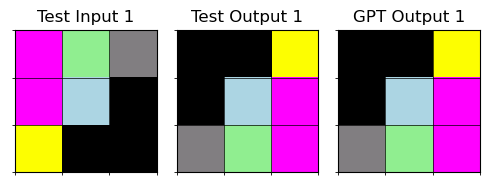

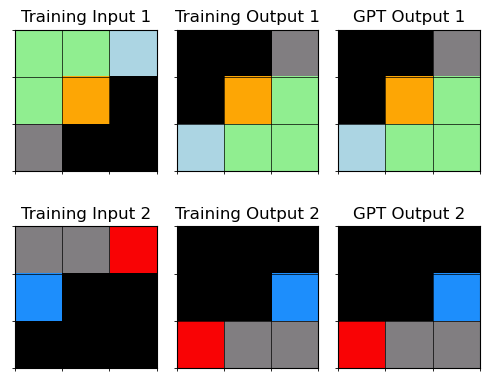

In [225]:
new_json_task = copy.deepcopy(json_task['train'])
# for each in new_json_task:
#     if 'input' in each: del each['input']
#     if 'output' in each: del each['output']
#     if 'code_output' in each: del each['code_output']
    
if error_msg != 'None':
    postamble = generate_postamble(task = f'Previous overall pattern: {overall_pattern}.\n\nYour code had compilation errors. Correct it.', reflection = 'reflect on why code did not run')
    
    code_string = output_string['python_program']
    print(preamble + '\n\n' + str(new_json_task).replace(', ',',') + '\n\n' + 'Your code to get output from input:\n'+code_string + '\n\n' 'Error Message:\n' + error_msg + '\n\n' + postamble)
    input_to_gpt4 = preamble + '\n\n' + str(new_json_task).replace(', ',',') + '\n\n' + 'Code to get output from input:\n'+code_string + '\n\n' 'Error Message:\n' + error_msg + '\n\n' + postamble
    
elif not correct:
    postamble = generate_postamble(task = f'''Previous overall pattern: {overall_pattern}\n\nYour code did not generate the correct output. 
'output' denotes the correct response to 'input', 'code_output' denotes the output from your generated code.
If 'code_output' is very close to 'output', you can treat 'code_output' as 'input' and extend your earlier code with the additional operations needed to transform it to 'output' ''',
    reflection = 'reflect on why code is incorrect, focusing on differences between output and code_output, focusing on grid size, object number, object size for all input-output pair')

    code_string = output_string['python_program']
    print(preamble + '\n\n' + str(new_json_task).replace(', ',',') + '\n\n' + 'Your code to get output from input:\n'+code_string + '\n\n' 'Error Message:\n' + error_msg + '\n\n' + postamble)
    input_to_gpt4 = preamble + '\n\n' + str(new_json_task).replace(', ',',') + '\n\n' + 'Code to get output from input:\n'+code_string + '\n\n' 'Error Message:\n' + error_msg + '\n\n' + postamble

plot_2d_grid(json_task)

## When solved, or give up, come here to display the final output of GPT

ARC Training Set index 59
6150a2bd.json

Training Set Status: True
Test Set Passed: True

Final GPT output string after 4 tries:
{'reflection': 'The grid size remains the same for all input-output pairs. The number of objects also remains the same, and their size does not change. It appears that the objects rotate by 180 degrees around the center of the grid. Pixels also seem to rotate, as the relative positions of the pixels of the same color appear to be maintained in the output grids.', 'description_pixel': 'The pixels in the grid are rotating by 180 degrees around the center of the grid. For example, a pixel at position (0,0) in the input grid is found at position (2,2) in the output grid. Similarly, a pixel at position (1,0) in the input grid is found at position (1,2) in the output grid, and so on.', 'description_object': 'The objects in the grid also appear to rotate by 180 degrees around the center of the grid. For example, an object with a top-left coordinate at (0,0) in the i

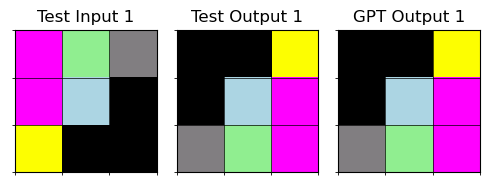

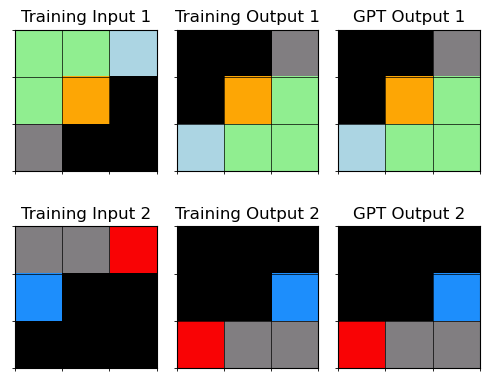

In [226]:
print('ARC Training Set index', index)
print(file_names[index])
print()
print('Training Set Status:', correct)
print('Test Set Passed:', test_correct)
print()
print('Final GPT output string after 4 tries:', output_string, sep = '\n')

plot_2d_grid(json_task)